### Set up

In [ ]:
# Install the library/package
# !pip install contextily
# !pip install geopandas

In [8]:
# Import the library/package
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.optimize as optimize
from datetime import datetime
from dateutil.relativedelta import relativedelta
import geopandas as gpd
import contextily as ctx
import networkx as nx
from urllib.request import urlopen
import json
import warnings
warnings.filterwarnings('ignore')

In [9]:
# Times-series data
pneumonia_rs = pd.read_excel('https://github.com/marliyehez/Epidemic-Forest/raw/main/Data/pneumonia-disease-data.xlsx')

# Datetime data
starting_date = datetime(year=2017, month=1, day=1).date()
date_array = [starting_date + relativedelta(months=i) for i in range(len(pneumonia_rs))]
date_array = [date.strftime("%b %y") for date in date_array]

# Name of the districts
cols_kecamatan = ['Gambir', 'Sawah Besar', 'Kemayoran', 'Senen', 'Cempaka Putih', 'Menteng', 'Tanah Abang', 'Johar Baru', 'Penjaringan', 'Tanjung Priok', 'Koja', 'Cilincing', 'Pademangan', 'Kelapa Gading', 'Cengkareng', 'Grogol Petamburan', 'Taman Sari', 'Tambora', 'Kebun Jeruk', 'Kali Deres', 'Palmerah', 'Kembangan', 'Tebet', 'Setiabudi', 'Mampang Prapatan', 'Pasar Minggu', 'Kebayoran Lama', 'Cilandak', 'Kebayoran Baru', 'Pancoran', 'Jagakarsa', 'Pesanggrahan', 'Matraman', 'Pulo Gadung', 'Jatinegara', 'Kramat Jati', 'Pasar Rebo', 'Cakung', 'Duren Sawit', 'Makasar', 'Ciracas', 'Cipayung']

# Processed population data
pop_dict = {'Cakung': 522229, 'Cempaka Putih': 94604, 'Cengkareng': 551492, 'Cilandak': 219122, 'Cilincing': 423527, 'Cipayung': 276211, 'Ciracas': 284382, 'Duren Sawit': 431166, 'Gambir': 97188, 'Grogol Petamburan': 196167, 'Jagakarsa': 345679, 'Jatinegara': 321838, 'Johar Baru': 144490, 'Kali Deres': 409083, 'Kebayoran Baru': 147778, 'Kebayoran Lama': 270646, 'Kebun Jeruk': 349390, 'Kelapa Gading': 141077, 'Kemayoran': 262822, 'Kembangan': 291046, 'Kep. Seribu Selatan': 11132, 'Kep. Seribu Utara': 16642, 'Koja': 337986, 'Kramat Jati': 306526, 'Makasar': 218324, 'Mampang Prapatan': 153485, 'Matraman': 179545, 'Menteng': 85355, 'Pademangan': 166406, 'Palmerah': 215048, 'Pancoran': 165528, 'Pasar Minggu': 322152, 'Pasar Rebo': 216396, 'Penjaringan': 279885, 'Pesanggrahan': 247491, 'Pulo Gadung': 302517, 'Sawah Besar': 134490, 'Senen': 120857, 'Setiabudi': 114443, 'Taman Sari': 124278, 'Tambora': 264117, 'Tanah Abang': 175895, 'Tanjung Priok': 391871, 'Tebet': 238851}

### Hierarchical Clustering

In [ ]:
def hcluster(disease, figsize=(12,5), cmap=plt.colormaps()[108], pop_scale=False):
    disease_scaled = disease.copy()
    if pop_scale:
        for i in range(len(disease_scaled)):
            scale = pop_dict[disease_scaled.index[i]]
            disease_scaled.iloc[i] = disease_scaled.iloc[i]/scale

    heatmap = sns.clustermap(
        disease_scaled, figsize=figsize,
        cmap=cmap, row_cluster=True, col_cluster=False,
        metric='euclidean',
        method='average',
    )

    heatmap.ax_row_dendrogram.set_visible(False)
    heatmap.ax_heatmap.set_xlabel('Time')
    heatmap.cax.set_title('Ratio of ARI cases\nto the population size', fontsize=10)

    return heatmap

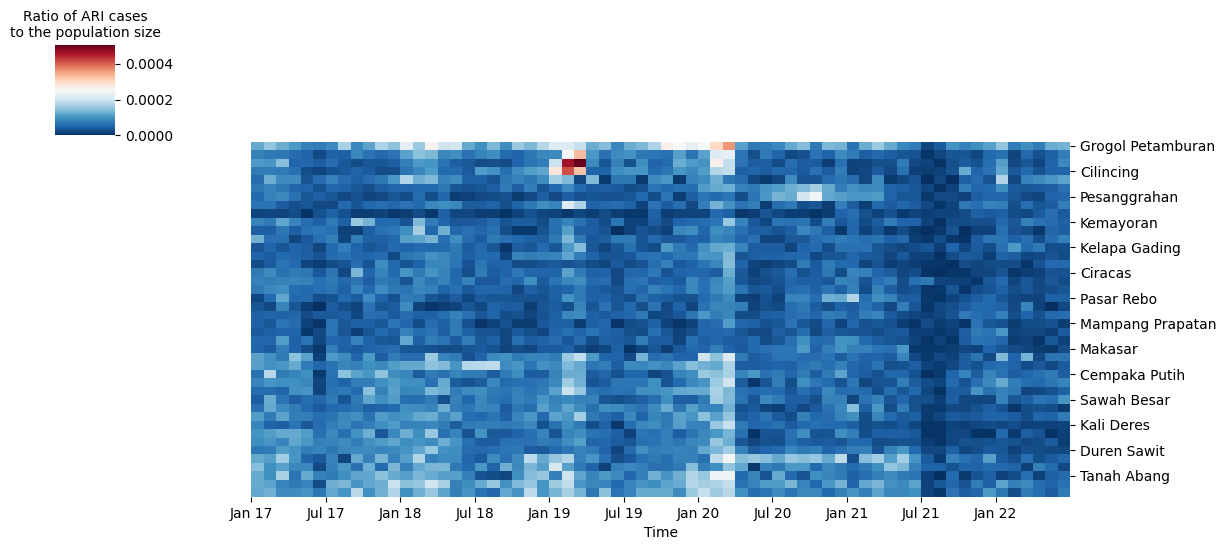

In [ ]:
# Times-series disease data
disease = pneumonia_rs[cols_kecamatan].transpose().iloc[:,:]

# Create the clustermap (with normalization)
x = hcluster(disease, pop_scale=True)
heatmap = x.ax_heatmap

# Ticks
n = len(pneumonia_rs)
ticks = [i for i in range(0,n,6)]
heatmap.set_xticks(ticks)
heatmap.set_xticklabels([date_array[i] for i in ticks], rotation=0)

# Show
plt.show()

In [ ]:
# Period
tmin, tmax = (19, 30)   # Period 2

'''
tmin, tmax = (5, 19)    # Period 1
tmin, tmax = (19, 30)   # Period 2
tmin, tmax = (31, 43)   # Period 3
tmin, tmax = (44, 55)   # Period 4
'''

# Times-series disease data for the period
disease_per = pneumonia_rs[cols_kecamatan].transpose().iloc[:, tmin:tmax]


# Gamma value
pct = 1/5000

# Gamma data
gamma_dict = {key: value*pct for key, value in pop_dict.items()}

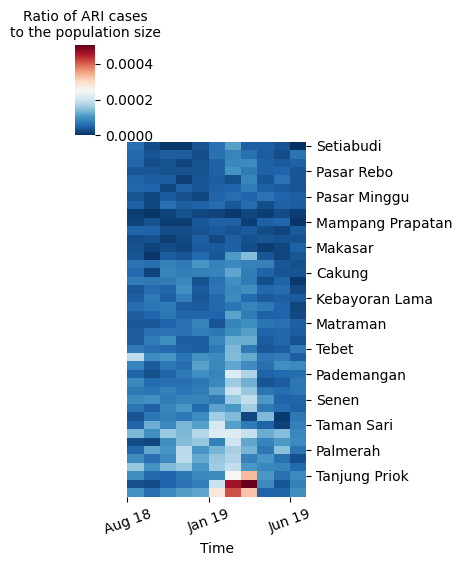

In [ ]:
# Create the clustermap
hcdata = hcluster(disease_per, pop_scale=True, figsize=(4,5))
heatmap = hcdata.ax_heatmap

# Ticks
n = tmax - tmin
ticks = [i for i in range(0, n, 5)]
heatmap.set_xticks(ticks)
heatmap.set_xticklabels([date_array[tmin+i] for i in ticks], rotation=20)

# Show
plt.show()

### Richards Curve

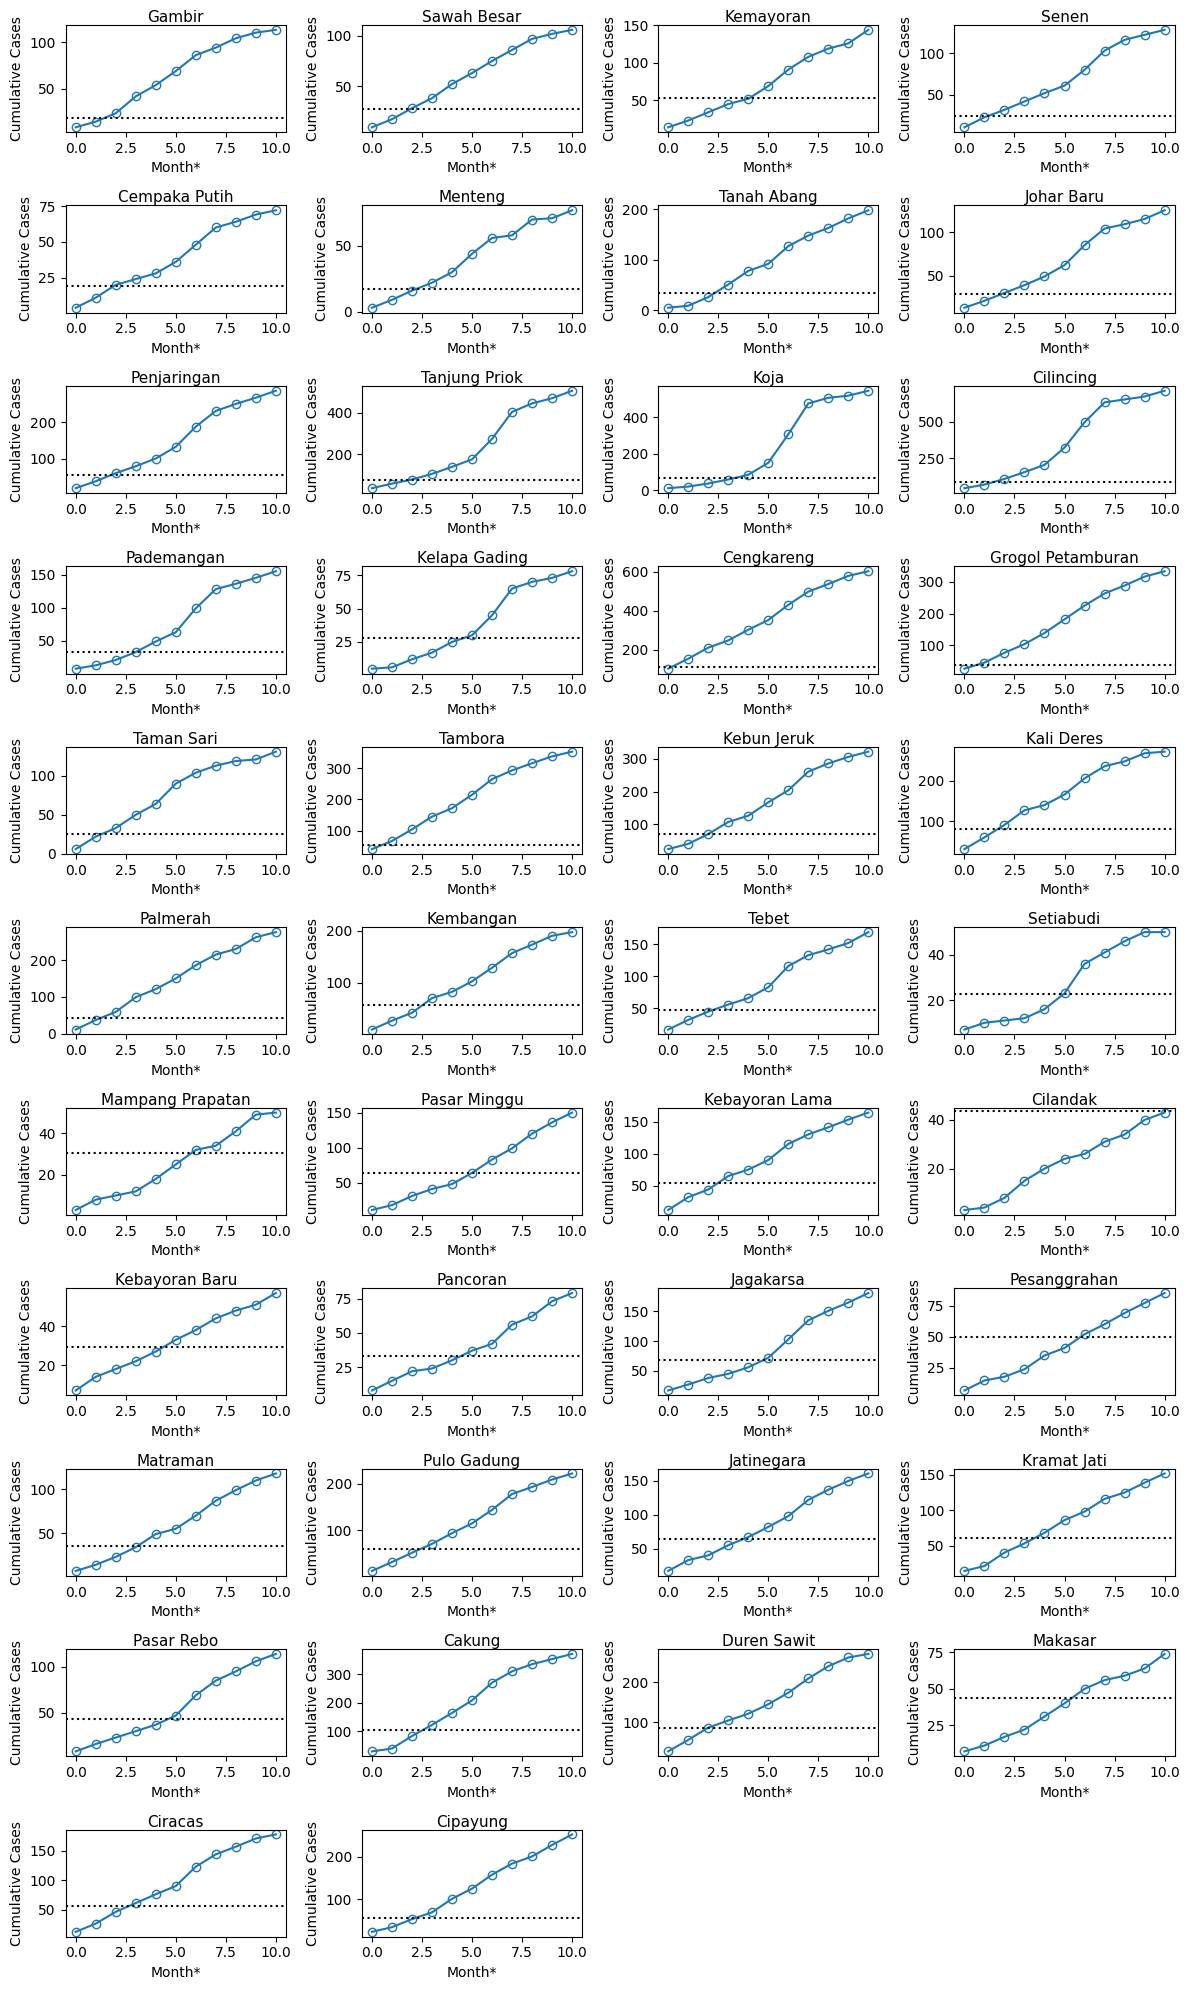

In [ ]:
# Subplots configs
ncols = 4
nrows = int(len(disease_per)/ncols) +1
fig, axs = plt.subplots(nrows, ncols, figsize=(12,20))
fig.delaxes(axs[10,2])
fig.delaxes(axs[10,3])
fig.tight_layout()

# Plotting
for i in range(len(disease_per)):
    plt.subplot(nrows, ncols, i+1)
    plt.plot(np.cumsum(disease_per.iloc[i]).values, 'o-', color='tab:blue', fillstyle='none')
    plt.title(disease_per.index[i], fontsize=11, y=0.95, loc='center')
    plt.xlabel('Month*')
    plt.ylabel('Cumulative Cases')
    plt.tight_layout()
    plt.axhline(y=gamma_dict[disease_per.index[i]], ls=':', color='black')
plt.show()

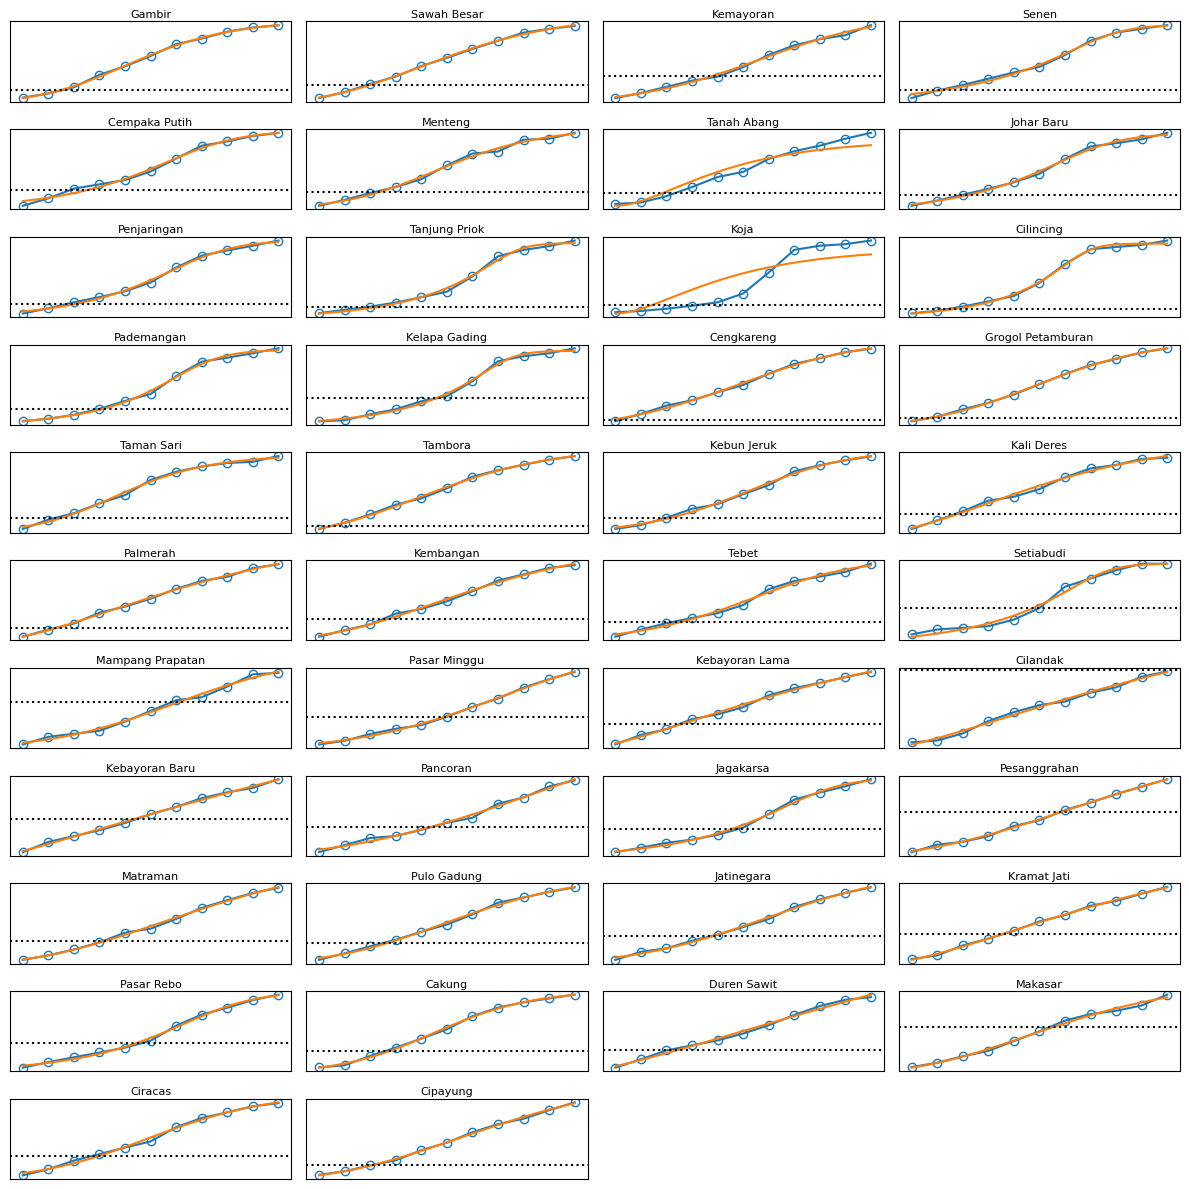

In [ ]:
# Initiate container for the result
onset_fitting = pd.DataFrame({
    'name': disease_per.index,
    'onset_date': -99
    })

# Richards
def generalized_logistic(t, p1, p2, p3, xi):
    return p1 / (1 + xi * np.exp(-p2 * (t - p3)))**(1 / xi)


# Subplots Configs
ncols = 4
nrows = int(len(disease_per)/ncols) +1
fig, axs = plt.subplots(nrows, ncols, figsize=(12,12))

# Delete last 2 subplots
fig.delaxes(axs[10,2])
fig.delaxes(axs[10,3])


for i in range(len(disease_per)):
    # Subplots
    plt.subplot(nrows, ncols, i+1)

    # Data
    y = np.cumsum(disease_per.iloc[i])
    t = np.arange(len(y))
    scale = np.max(y)
    y_fit = y/scale

    try:
        # Fit the curve to the data
        params, _ = optimize.curve_fit(generalized_logistic, t, y_fit, maxfev = 1000)

        # Extract the fitted parameters
        p1_fit, p2_fit, p3_fit, xi_fit = params
        p1_fit = p1_fit*scale

        # Calculating onset date
        gamma = gamma_dict[disease_per.index[i]]
        equation_to_solve = lambda t: generalized_logistic(t, p1=p1_fit, p2=p2_fit, p3=p3_fit, xi=xi_fit) - gamma
        solution = optimize.root(equation_to_solve, x0=0)
        onset_date = round(solution.x[0])

        # Save onset date to dataframe
        onset_fitting.iloc[i,1] = onset_date

        # Generate points on the fitted curve
        t_fit = np.linspace(0, len(y)-1, 100)
        y_fit = generalized_logistic(t_fit, p1_fit, p2_fit, p3_fit, xi_fit)

        # Plotting
        plt.plot(t, y, 'o-', fillstyle='none', label='Data')
        plt.plot(t_fit, y_fit, label='Curve-fitting')

        plt.gca().set_xticks([])
        plt.gca().set_yticks([])
        plt.title(disease_per.index[i], fontsize=8, y=0.95, loc='center')
        plt.axhline(y=gamma_dict[disease_per.index[i]], ls=':', color='black')
        plt.tight_layout()

    except RuntimeError:
        ## Plot nothing
        plt.plot([],[])
        plt.gca().set_xticks([])
        plt.gca().set_yticks([])
        plt.title(disease_per.index[i], fontsize=8, y=0.95, loc='center')
        plt.tight_layout()

# Show
plt.show()

#### Onset Time Result in DataFrame

In [10]:
# Onset date dataframes
onset_pneu_per1 = pd.DataFrame({'name': {0: 'Gambir', 1: 'Sawah Besar', 2: 'Kemayoran', 3: 'Senen', 4: 'Cempaka Putih', 5: 'Menteng', 6: 'Tanah Abang', 7: 'Johar Baru', 8: 'Penjaringan', 9: 'Tanjung Priok', 10: 'Koja', 11: 'Cilincing', 12: 'Pademangan', 13: 'Kelapa Gading', 14: 'Cengkareng', 15: 'Grogol Petamburan', 16: 'Taman Sari', 17: 'Tambora', 18: 'Kebun Jeruk', 19: 'Kali Deres', 20: 'Palmerah', 21: 'Kembangan', 22: 'Tebet', 23: 'Setiabudi', 24: 'Mampang Prapatan', 25: 'Pasar Minggu', 26: 'Kebayoran Lama', 27: 'Cilandak', 28: 'Kebayoran Baru', 29: 'Pancoran', 30: 'Jagakarsa', 31: 'Pesanggrahan', 32: 'Matraman', 33: 'Pulo Gadung', 34: 'Jatinegara', 35: 'Kramat Jati', 36: 'Pasar Rebo', 37: 'Cakung', 38: 'Duren Sawit', 39: 'Makasar', 40: 'Ciracas', 41: 'Cipayung'}, 'onset_date': {0: 2, 1: 2, 2: 2, 3: 2, 4: 2, 5: 2, 6: 2, 7: 0, 8: 2, 9: 2, 10: 4, 11: 3, 12: 4, 13: 3, 14: 2, 15: 2, 16: 2, 17: 2, 18: 2, 19: 2, 20: 1, 21: 2, 22: 3, 23: 3, 24: 4, 25: 4, 26: 4, 27: 8, 28: 3, 29: 5, 30: 4, 31: 5, 32: 2, 33: 2, 34: 2, 35: 3, 36: 3, 37: 3, 38: 2, 39: 3, 40: 3, 41: 2}})
onset_pneu_per2 = pd.DataFrame({'name': {0: 'Gambir', 1: 'Sawah Besar', 2: 'Kemayoran', 3: 'Senen', 4: 'Cempaka Putih', 5: 'Menteng', 6: 'Tanah Abang', 7: 'Johar Baru', 8: 'Penjaringan', 9: 'Tanjung Priok', 10: 'Koja', 11: 'Cilincing', 12: 'Pademangan', 13: 'Kelapa Gading', 14: 'Cengkareng', 15: 'Grogol Petamburan', 16: 'Taman Sari', 17: 'Tambora', 18: 'Kebun Jeruk', 19: 'Kali Deres', 20: 'Palmerah', 21: 'Kembangan', 22: 'Tebet', 23: 'Setiabudi', 24: 'Mampang Prapatan', 25: 'Pasar Minggu', 26: 'Kebayoran Lama', 27: 'Cilandak', 28: 'Kebayoran Baru', 29: 'Pancoran', 30: 'Jagakarsa', 31: 'Pesanggrahan', 32: 'Matraman', 33: 'Pulo Gadung', 34: 'Jatinegara', 35: 'Kramat Jati', 36: 'Pasar Rebo', 37: 'Cakung', 38: 'Duren Sawit', 39: 'Makasar', 40: 'Ciracas', 41: 'Cipayung'}, 'onset_date': {0: 1, 1: 2, 2: 4, 3: 1, 4: 3, 5: 2, 6: 2, 7: 2, 8: 2, 9: 2, 10: 3, 11: 2, 12: 3, 13: 5, 14: 0, 15: 1, 16: 2, 17: 0, 18: 2, 19: 2, 20: 1, 21: 3, 22: 3, 23: 5, 24: 6, 25: 5, 26: 3, 27: 10, 28: 4, 29: 4, 30: 5, 31: 6, 32: 3, 33: 3, 34: 4, 35: 4, 36: 4, 37: 3, 38: 2, 39: 6, 40: 3, 41: 2}})
onset_pneu_per3 = pd.DataFrame({'name': {0: 'Gambir', 1: 'Sawah Besar', 2: 'Kemayoran', 3: 'Senen', 4: 'Cempaka Putih', 5: 'Menteng', 6: 'Tanah Abang', 7: 'Johar Baru', 8: 'Penjaringan', 9: 'Tanjung Priok', 10: 'Koja', 11: 'Cilincing', 12: 'Pademangan', 13: 'Kelapa Gading', 14: 'Cengkareng', 15: 'Grogol Petamburan', 16: 'Taman Sari', 17: 'Tambora', 18: 'Kebun Jeruk', 19: 'Kali Deres', 20: 'Palmerah', 21: 'Kembangan', 22: 'Tebet', 23: 'Setiabudi', 24: 'Mampang Prapatan', 25: 'Pasar Minggu', 26: 'Kebayoran Lama', 27: 'Cilandak', 28: 'Kebayoran Baru', 29: 'Pancoran', 30: 'Jagakarsa', 31: 'Pesanggrahan', 32: 'Matraman', 33: 'Pulo Gadung', 34: 'Jatinegara', 35: 'Kramat Jati', 36: 'Pasar Rebo', 37: 'Cakung', 38: 'Duren Sawit', 39: 'Makasar', 40: 'Ciracas', 41: 'Cipayung'}, 'onset_date': {0: 2, 1: 3, 2: 4, 3: 2, 4: 3, 5: 3, 6: 1, 7: 2, 8: 1, 9: 2, 10: 2, 11: 2, 12: 4, 13: 3, 14: 1, 15: 0, 16: 2, 17: 1, 18: 2, 19: 1, 20: 1, 21: 3, 22: 4, 23: 3, 24: 5, 25: 4, 26: 2, 27: 7, 28: 3, 29: 4, 30: 3, 31: 4, 32: 2, 33: 2, 34: 2, 35: 3, 36: 4, 37: 2, 38: 2, 39: 5, 40: 3, 41: 1}})
onset_pneu_per4 = pd.DataFrame({'name': {0: 'Gambir', 1: 'Sawah Besar', 2: 'Kemayoran', 3: 'Senen', 4: 'Cempaka Putih', 5: 'Menteng', 6: 'Tanah Abang', 7: 'Johar Baru', 8: 'Penjaringan', 9: 'Tanjung Priok', 10: 'Koja', 11: 'Cilincing', 12: 'Pademangan', 13: 'Kelapa Gading', 14: 'Cengkareng', 15: 'Grogol Petamburan', 16: 'Taman Sari', 17: 'Tambora', 18: 'Kebun Jeruk', 19: 'Kali Deres', 20: 'Palmerah', 21: 'Kembangan', 22: 'Tebet', 23: 'Setiabudi', 24: 'Mampang Prapatan', 25: 'Pasar Minggu', 26: 'Kebayoran Lama', 27: 'Cilandak', 28: 'Kebayoran Baru', 29: 'Pancoran', 30: 'Jagakarsa', 31: 'Pesanggrahan', 32: 'Matraman', 33: 'Pulo Gadung', 34: 'Jatinegara', 35: 'Kramat Jati', 36: 'Pasar Rebo', 37: 'Cakung', 38: 'Duren Sawit', 39: 'Makasar', 40: 'Ciracas', 41: 'Cipayung'}, 'onset_date': {0: 0, 1: 3, 2: 3, 3: 2, 4: 2, 5: 3, 6: 2, 7: 2, 8: 2, 9: 2, 10: 5, 11: 3, 12: 4, 13: 3, 14: 2, 15: 1, 16: 1, 17: 2, 18: 2, 19: 3, 20: 2, 21: 3, 22: 3, 23: 2, 24: 4, 25: 4, 26: 0, 27: 6, 28: 2, 29: 3, 30: 2, 31: 0, 32: 2, 33: 4, 34: 3, 35: 2, 36: 1, 37: 4, 38: 2, 39: 1, 40: 3, 41: 3}})

### Epidemic Forest

In [11]:
# Function
def euclidean_dist(pos1, pos2):
    x1, y1 = pos1
    x2, y2 = pos2
    return np.sqrt( (x1-x2)**2 +  (y1-y2)**2)

def P_scailing(data, child_onset):
    data_scaled = np.array(data) - child_onset
    scaler = np.max(np.abs(data_scaled))
    if scaler != 0:
        data_scaled = data_scaled / scaler
    return data_scaled


# Geospatial data
link = 'https://raw.githubusercontent.com/marliyehez/Epidemic-Forest/main/Data/jakarta-district-geographical-data.json'

# Reading the Geospatial JSON data
with urlopen(link) as response:
    geojson = json.load(response)

# Read GeoDataframe
df_geo = gpd.read_file(link)


# Standardizing district names
adjust_kecamatan = {
    'Kalideres': 'Kali Deres', 'Kebon Jeruk': 'Kebun Jeruk',
    'Pulogadung': 'Pulo Gadung'}

df_geo['name'] = df_geo['name'].str.title().str.replace(u'\xa0', u'')\
                                .replace(adjust_kecamatan)

# Abbreviations for district names
df_geo['code'] = ['GAM', 'SB', 'MAY', 'SEN', 'CP', 'MEN', 'TA', 'JB', 'PEN', 'TP', 'KOJ', 'CLC', 'PAD', 'KG', 'CKG', 'GP', 'TS', 'TAM', 'KEB', 'KD', 'PAL', 'KEM', 'TEB', 'SET', 'MP', 'PM', 'KL', 'CLD', 'KB', 'PAN', 'JAG', 'PES', 'MAT', 'PG', 'JAT', 'KRA', 'PR', 'CAK', 'DS', 'MAK', 'CIR', 'CIP']

# Calculating centroid
df_geo['pos'] = [(point.x, point.y) for point in df_geo.geometry.centroid]

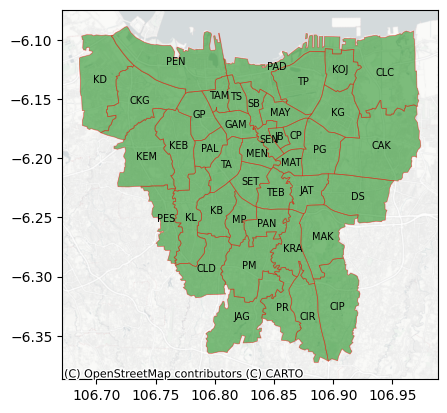

In [12]:
# Plotting Code for Districts (Abbreviations) in GeoDataFrame

# Initialize the Axes with GeoDataFrame plot settings
ax = df_geo.plot(facecolor='green', edgecolor='red', alpha=0.5, linewidth=0.5)

# Add basemap using contextily with the same Coordinate Reference System (CRS) as GeoDataFrame
ctx.add_basemap(
    ax, crs=df_geo.crs,
    source=ctx.providers.CartoDB.PositronNoLabels)

# Add text annotations to the plot based on 'pos' and 'code' columns in GeoDataFrame
# Iterate over rows in GeoDataFrame and place code text at specified positions
for idx, row in df_geo.iterrows():
    plt.text(row['pos'][0], row['pos'][1], row['code'], fontsize=7, ha='center', va='center')

# Display the plot
plt.show()

In [13]:
# Period
tmin, tmax = (19, 30)   # Period 2

'''
tmin, tmax = (5, 19)    # Period 1
tmin, tmax = (19, 30)   # Period 2
tmin, tmax = (31, 43)   # Period 3
tmin, tmax = (44, 55)   # Period 4
'''

# Times-series disease data for the period
disease_per = pneumonia_rs[cols_kecamatan].transpose().iloc[:, tmin:tmax]

# Defines a dataframe for onset time
onset_df = onset_pneu_per2.copy()


# Create the result dataframe
df = pd.DataFrame({
    'name': df_geo['name'],
    'pos': df_geo['pos'],
    'population': df_geo['name'].map(pop_dict)
})

# Join onset time to the dataframe
df = df.merge(onset_df, how='left', on='name')

# Cummulative sum of disease
cumsum_disease_dict = disease_per.sum(axis=1).to_dict()
df['disease_cumsum'] = df['name'].map(cumsum_disease_dict)

# Neighborhood matrix
adj = np.zeros([len(df_geo),len(df_geo)], dtype=int)
for x in gpd.sjoin(df_geo, df_geo, predicate='touches')['index_right'].items():
    adj[x] = 1

In [14]:
# =============  EPIDEMIC FOREST ALGORITHM v3 =============

# Initiate the container for the result
df['parent'] = -99

# Iterate every node (district) in the graph
for chosen_node in df.index:

    # If the chosen node satisfy the onset time rule
    if (0 <= df.iloc[chosen_node]['onset_date'] < disease_per.shape[1]):

        # Create a container for Candidate 2
        can_2_list = []

        # Iterate every other node that neighbors with
        # the chosen node (Candidate 1)
        for node, con in enumerate(adj[chosen_node]):
            if con == 1:

                # If Candidate 1 satisfy the onset time rule, then it
                # is Candidate 2. Add it to the container.
                if 0 <= df.iloc[node]['onset_date'] < df.iloc[chosen_node]['onset_date']:
                    can_2_list.append(node)


        # DETERMINING THE PARENT

        # If there's only one Candidate 2, then it is the parent for the chosen node
        if len(can_2_list) == 1:
            df.loc[chosen_node,'parent'] = can_2_list[0]


        # If there are more than one Candidate 2
        elif len(can_2_list) > 1:

            # Define variables that holds the information for maximum SOL and its node
            max_SoL, can_2 = (-99, -99)

            # Factors to be considerated
            Dt_list = [ df.iloc[chosen_node]['onset_date'] - df.iloc[node]['onset_date'] for node in can_2_list ]
            Ds_list = [ euclidean_dist(df.iloc[chosen_node]['pos'], df.iloc[node]['pos']) for node in can_2_list ]
            P_list = [ disease_per.iloc[node].values[ df.iloc[chosen_node]['onset_date'] ] for node in can_2_list ]

            # Transform these factors
            Dt_list = np.array(Dt_list) / np.min(Dt_list)
            Ds_list = np.array(Ds_list) / np.min(Ds_list)
            P_list = P_scailing(P_list, df.iloc[chosen_node]['onset_date'])


            # Calculating Strength of Linkage (SoL)
            for i, node in enumerate(can_2_list):

                # Temporal distance
                Dt = Dt_list[i]

                # Spatial distance
                Ds = Ds_list[i]

                # Prevalence disease
                P = P_list[i]

                # Weight
                Ws, Wt = (0.25, 0.25)        #     <- Change the weight here!

                # Formula
                SoL = Ws/Ds + Wt/Dt + (1-Ws-Wt)*P

                # Determining the parent
                if SoL > max_SoL:
                    max_SoL = SoL
                    can_2 = node

            # Save the result of parent for the chosen node
            df.loc[chosen_node,'parent'] = can_2

In [15]:
# ========= CONFIGURATION =========

# Some nodes tobe droped (no onset date)
filt = df['onset_date'] == -99
drop_id1 = df[filt].index

# Some nodes tobe droped (no parent, and included no onset date)
filt = df['parent'] == -99
drop_id2 = df[filt].index

#==================================

# Create an empty graph object
G = nx.DiGraph()

# Add nodes from DataFrame
G.add_nodes_from(df.drop(drop_id1).index)
node_color = df.drop(drop_id1)['onset_date'].values
node_size = df.drop(drop_id1)['disease_cumsum'].values
node_size = node_size/5
pos = df.drop(drop_id1)['pos'].values
labels = df.drop(drop_id1)['name'].to_dict()
cmap=plt.colormaps()[117]

# Add edges from DataFrame
edges = [(parent, child) for (child, parent) in df.drop(drop_id2)['parent'].items()]
G.add_edges_from(edges)

# Arrow settings
arrow_settings = {'arrowstyle': '-|>', 'arrowsize': 8}

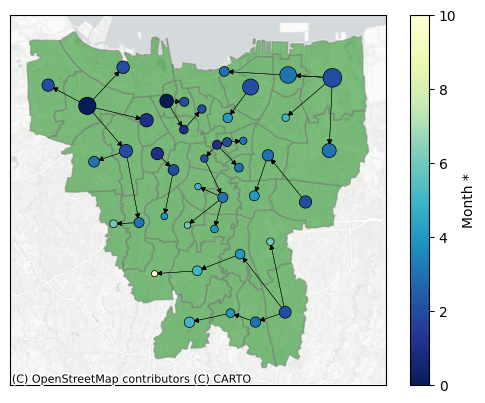

0.25, 0.25, 0.5


In [16]:
# ========= PLOT WITH BASEMAP =========
# Initialize the Axes
ax = df_geo.plot(facecolor='green', edgecolor="grey", alpha=0.5)

# Add basemap
ctx.add_basemap(
        ax,
        crs=df_geo.crs,
        source=ctx.providers.CartoDB.PositronNoLabels,
)

# Visualize the network
nx.draw_networkx(G, with_labels=False,
                node_size=node_size, linewidths=2,
                node_color='black', cmap=cmap, pos=pos,
                width=0.3,
                ax=ax,
                **arrow_settings)
nx.draw_networkx(G, with_labels=False,
                node_size=node_size,
                node_color=node_color, cmap=cmap, pos=pos,
                width=0.3,
                ax=ax,
                **arrow_settings)

# Show the colorbar
cbar = plt.colorbar(
    plt.cm.ScalarMappable(
        cmap=cmap,
        norm=plt.Normalize(
            vmin=min(node_color),
            vmax=max(node_color),
        )
    ),
    label='Month *',
)

# Show
plt.show()
print(f'{Ws}, {Wt}, {1-Ws-Wt}')

In [ ]:
# Edge (arrow) color to produce figure 4 and figure 5 (a and b)

# Figure 4
red_edges_4 = [
    (17, 0), (0, 1), (9, 2), (7, 4), (3, 5), (3, 7), (11, 10), (14, 15),
    (15, 18), (5, 22), (25, 24), (35, 25), (18, 26), (6, 28), (36, 30),
    (3, 32), (38, 33), (33, 34), (41, 35), (40, 36), (41, 40)
]

edge_color = ['firebrick' if edge in red_edges_4 else 'black' for edge in edges]
width = [1.4 if edge in red_edges_4 else 0.7 for edge in edges]


# Figure 5a
red_edges_5a = [
    (17, 0), (0, 1), (9, 2), (7, 4), (3, 5), (3, 7), (9, 12), (17, 15),
    (14, 19), (18, 21), (22, 24), (35, 25), (18, 26), (22, 29), (36, 30),
    (3, 32), (38, 33), (33, 34), (41, 35), (11, 37), (41, 40)
]

edge_color = ['firebrick' if edge in red_edges_5a else 'black' for edge in edges]
width = [1.4 if edge in red_edges_5a else 0.7 for edge in edges]


# Figure 5b
orange_edges = [
    (15, 8), (23, 24), (40, 36)
]

edge_color = ['darkorange' if edge in orange_edges else 'black' for edge in edges]
width = [1.4 if edge in orange_edges else 0.7 for edge in edges]